In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

In [2]:
df = pd.read_csv('data.csv')
df.head()

,average_speed_kph,distance,elevation_gain,expected_precipitation,time_of_departure_min,energy_consumption
0,88.5,22855.9,2365.4,5.6,61.3,4033.0
1,72.1,38268.0,5302.5,8.9,52.7,4174.0
2,15.1,11561.5,1211.6,6.0,844.1,3995.0
3,56.9,42697.4,6108.0,2.6,906.8,4714.0
4,86.3,21826.6,1833.6,3.7,128.0,3911.0


In [3]:
X, y = df.drop(columns='energy_consumption'), df['energy_consumption']
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [4]:
models = {
    'LinearRegression': LinearRegression(),
    'RandomForestRegressor': RandomForestRegressor(),
    'AdaBoostRegressor': AdaBoostRegressor(),
}

y_preds = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_preds[model_name] = model.predict(X_test)

In [5]:
mae_scores = {model_name: mae(y_test, y_pred) for model_name, y_pred in y_preds.items()}
mae_scores = dict(sorted(mae_scores.items(), key=lambda item: item[1]))  # Sort by best score

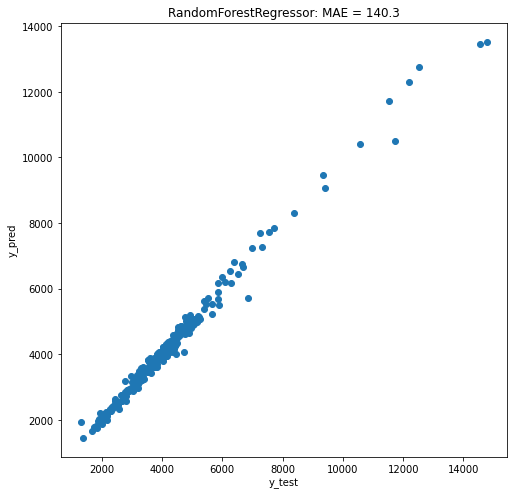

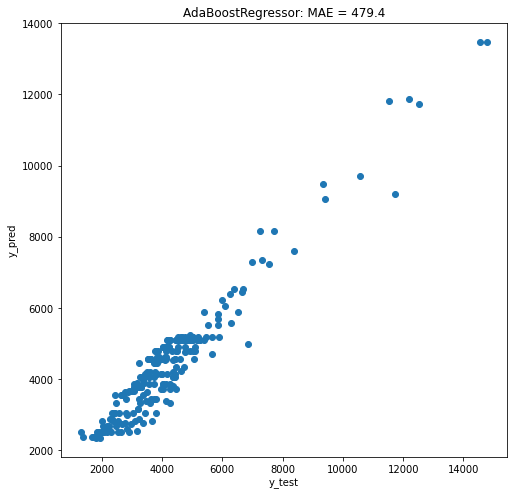

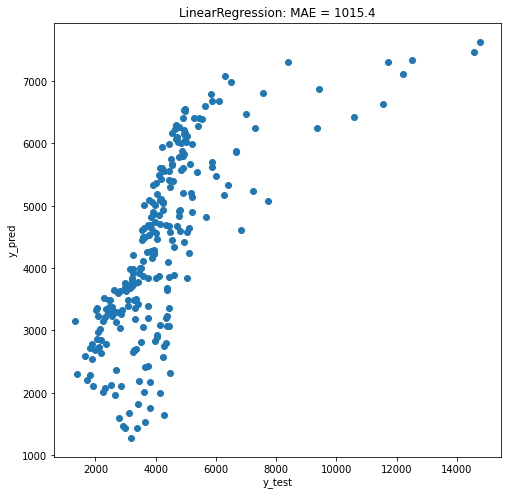

In [6]:
for model_name, mae_score in mae_scores.items():
    plt.figure(figsize=(8,8))
    plt.scatter(y_test, y_preds[model_name])
    plt.title(f"{model_name}: MAE = {mae_score:.1f}")
    plt.xlabel("y_test")
    plt.ylabel("y_pred")
    plt.show()

In [8]:
best_model = next(iter(mae_scores))

initial_type = [('float_input', FloatTensorType([None, 5]))]
onx = convert_sklearn(models[best_model], initial_types=initial_type)
with open("model.onnx", "wb") as f:
    f.write(onx.SerializeToString())